In [45]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [46]:
from research.strings import INSPECTION_ID

In [47]:
df = pd.read_csv("data/inspections_train.csv")
print("Read {} records.".format(len(df)))

Read 17075 records.


In [48]:
df.head().T

,0,1,2,3,4
criticalFound,0,0,0,0,0
Inspection_Date,15736,15265,15265,15266,15267
License,30790,1475890,1740130,1447363,1679459
Inspection_ID,269961,507211,507212,507216,507219
Business_ID,30790-20110416,1475890-20110416,1740130-20110216,1447363-20110216,1679459-20100216
Inspector_blue,0,1,1,1,1
Inspector_brown,0,0,0,0,0
Inspector_green,1,0,0,0,0
Inspector_orange,0,0,0,0,0
Inspector_purple,0,0,0,0,0


In [49]:
def get_violation_codes(report):
    if pd.isnull(report):
        return []
    else:
        codes = [int(comment.split(".")[0]) for comment in report.split(" | ")]
        return codes
        

def get_violation_level(code):
    if code <= 14:
        return "critical"
    elif code <= 29:
        return "serious"
    elif code <= 44 or code == 70:
        return "minor"
    else:
        return "unknown"

In [57]:
code_array = [get_violation_codes(report) for report in df["violations"].values]
code_array[10:20]

[[32, 33, 38],
 [34, 38],
 [9, 12, 24, 31, 32, 33, 34, 35, 38],
 [33],
 [33],
 [32, 35],
 [32, 35],
 [33, 36, 37],
 [31, 33, 35, 37, 43],
 [18, 32, 34, 35, 38]]

In [55]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb_all = MultiLabelBinarizer()
all_vio_mat = pd.DataFrame(mlb_all.fit_transform(code_array), columns=mlb_all.classes_)
# all_vio_mat[INSPECTION_ID] = df[INSPECTION_ID]
all_vio_mat.head()

,1,2,3,4,5,6,7,8,9,10,...,36,37,38,39,40,41,42,43,44,70
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0


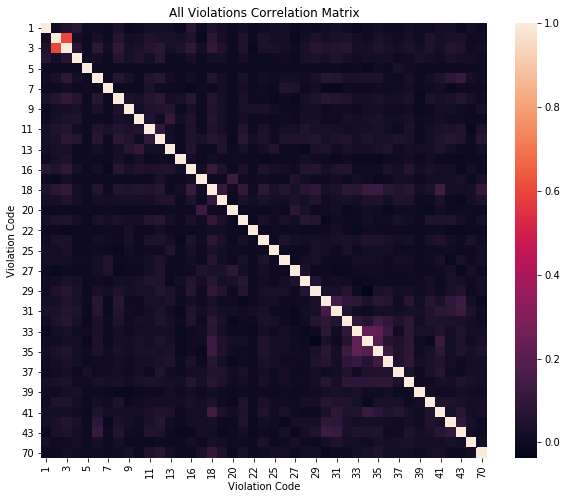

In [82]:
sns.heatmap(all_vio_mat.corr())
plt.gcf().set_size_inches(10, 8)
plt.xlabel("Violation Code")
plt.ylabel("Violation Code")
plt.title("All Violations Correlation Matrix")
plt.show()

In [58]:
crit_array = [list(filter(lambda code: get_violation_level(code) == "critical", arr)) for arr in code_array]
crit_array[10:20]

[[], [], [9, 12], [], [], [], [], [], [], []]

In [61]:
mlb_crit = MultiLabelBinarizer()
crit_mat = pd.DataFrame(mlb_crit.fit_transform(crit_array), columns=mlb_crit.classes_)
# crit_mat[INSPECTION_ID] = df[INSPECTION_ID]
crit_mat[10:20]

,1,2,3,4,5,6,7,8,9,10,11,12,13,14
10,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12,0,0,0,0,0,0,0,0,1,0,0,1,0,0
13,0,0,0,0,0,0,0,0,0,0,0,0,0,0
14,0,0,0,0,0,0,0,0,0,0,0,0,0,0
15,0,0,0,0,0,0,0,0,0,0,0,0,0,0
16,0,0,0,0,0,0,0,0,0,0,0,0,0,0
17,0,0,0,0,0,0,0,0,0,0,0,0,0,0
18,0,0,0,0,0,0,0,0,0,0,0,0,0,0
19,0,0,0,0,0,0,0,0,0,0,0,0,0,0


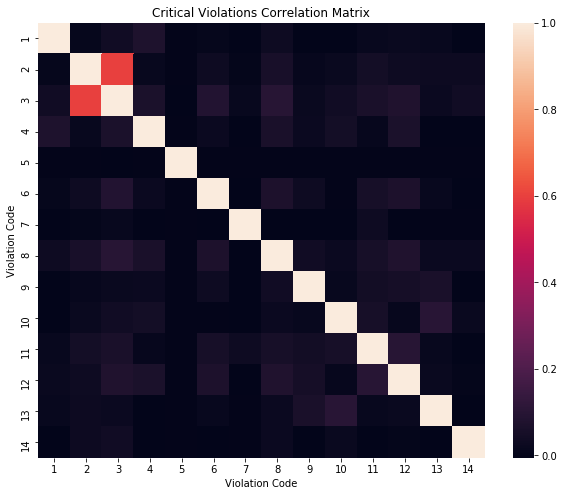

In [83]:
sns.heatmap(crit_mat.corr())
plt.gcf().set_size_inches(10, 8)
plt.xlabel("Violation Code")
plt.ylabel("Violation Code")
plt.title("Critical Violations Correlation Matrix")
plt.show()